## Fetch Data

In [1]:
# Import modules
# Read data
import os
import sys
import pickle

# Dataframes
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import concat
# display and formatting
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

#Data Prep

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import featuretools as ft


# Config
folder = './data/'
file = 'train_Wc8LBpr.csv'


def _ReadCsv_pd(datafolder, file):
    """Read CSV file from remote path.
    Returns:
      The contents of CSV file.
    Raises:
      ValueError: Unable to read file
    """
    try:
        df = pd.read_csv(os.path.join(datafolder, file))
        print(file, ": Read csv to dataframe sucessfully")
        print("Shape of dataframe", df.shape, "Memory Usage", sys.getsizeof(df))
    except Exception as e:
        raise type(e)(e)
        exit()
    return(df)

df = _ReadCsv_pd(folder, file)
df_copy = df.copy()

def __GetDuplicateCount(df, col_name):
    try:
        print(pd.concat(g for _, g in df.groupby() if len(g) > 1))
        
    except:
        print("Dataframe doesnt have dups")
    return()

__GetDuplicateCount(df,"Trip_ID")

df.head()

train_Wc8LBpr.csv : Read csv to dataframe sucessfully
Shape of dataframe (131662, 14) Memory Usage 51235120
Dataframe doesnt have dups


,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.00,2.43,A,A,3.90,0,40.00,46,60,Female,2
1,T0005689461,29.47,B,10.00,2.78,B,A,3.45,0,38.00,56,78,Male,2
2,T0005689464,41.58,NaN,10.00,nan,NaN,E,3.50,2,nan,56,77,Male,2
3,T0005689465,61.56,C,10.00,nan,NaN,A,3.45,0,nan,52,74,Male,3
4,T0005689467,54.95,C,10.00,3.03,B,A,3.40,4,51.00,49,102,Male,2


## Prepare Data

In [3]:
def __GetIntCols(df, collist):
    for col in collist:
        df[col] = df[col].str.extract('(\d+)').astype(float)
    return(df)

def get_prop_missing_values(df):
    print("Null info in data: ", df.isna().any().sum())
    #prop_missing = round((df[df.columns[:]].isnull().sum()/df[df.columns[:]].count())*100,4)
    prop_missing = round((df.isnull().sum()/len(df))*100,2)
    print("These are the missing values proportions in each column")
    print(prop_missing)
    return()


def __SetColumnTypes(df, change_to_int_list = ['col1']):
    cols = df.columns
    try:
        df = __GetIntCols(df, change_to_int_list)
    except:
        pass
    # Check for any null values in the data
    print("% Missing data in each column \n",get_prop_missing_values(df))
    return(df, cols)


# For this particular dataframe

clean_df, cols = __SetColumnTypes(df)

# Get list of column by types
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = list(set(cols) - set(numeric_cols))
categorical_cols.remove('Trip_ID')
numeric_cols.remove('Surge_Pricing_Type')
print(categorical_cols)
print(numeric_cols)

Null info in data:  5
These are the missing values proportions in each column
Trip_ID                        0.00
Trip_Distance                  0.00
Type_of_Cab                   15.35
Customer_Since_Months          4.50
Life_Style_Index              15.34
Confidence_Life_Style_Index   15.34
Destination_Type               0.00
Customer_Rating                0.00
Cancellation_Last_1Month       0.00
Var1                          53.95
Var2                           0.00
Var3                           0.00
Gender                         0.00
Surge_Pricing_Type             0.00
dtype: float64
% Missing data in each column 
 ()
['Confidence_Life_Style_Index', 'Type_of_Cab', 'Destination_Type', 'Gender']
['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index', 'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3']


## Explore Data

Distribution for
Confidence_Life_Style_Index
B    40355
C    35967
A    35147
Name: Confidence_Life_Style_Index, dtype: int64
Distribution for
Type_of_Cab
B    31136
C    28122
A    21569
D    18991
E    11634
Name: Type_of_Cab, dtype: int64
Distribution for
Destination_Type
A    77597
B    29555
C     7484
D     6588
E     2717
F     1950
G     1489
H     1260
I      813
J      695
K      680
L      643
N       98
M       93
Name: Destination_Type, dtype: int64
Distribution for
Gender
Male      93900
Female    37762
Name: Gender, dtype: int64


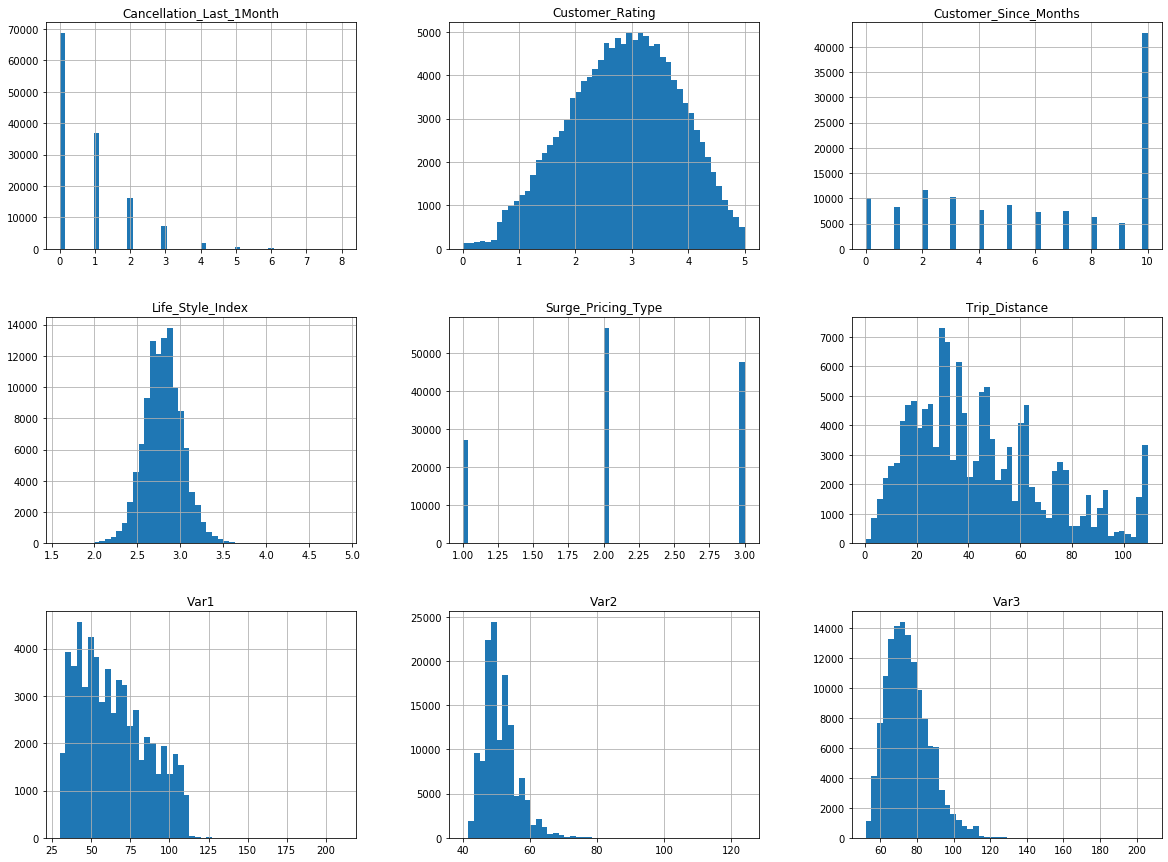

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
count,131662.00,125742.00,111469.00,131662.00,131662.00,60632.00,131662.00,131662.00,131662.00
mean,44.20,6.02,2.80,2.85,0.78,64.20,51.20,75.10,2.16
std,25.52,3.63,0.23,0.98,1.04,21.82,4.99,11.58,0.74
min,0.31,0.00,1.60,0.00,0.00,30.00,40.00,52.00,1.00
25%,24.58,3.00,2.65,2.15,0.00,46.00,48.00,67.00,2.00
50%,38.20,6.00,2.80,2.90,0.00,61.00,50.00,74.00,2.00
75%,60.73,10.00,2.95,3.58,1.00,80.00,54.00,82.00,3.00
max,109.23,10.00,4.88,5.00,8.00,210.00,124.00,206.00,3.00


In [4]:
def __ExploringDataframe(df, cat_list):
    for col in cat_list:
        print("Distribution for")
        print(col)
        print(df[col].value_counts())

    # Above data as plots
    df.hist(bins=50, figsize=(20,15))
    plt.show()
    return()

__ExploringDataframe(clean_df, categorical_cols)
# Lets look at the rest of the fields - we can check out the numeric data using describe method
clean_df.describe()

##### Some Preprocessing Steps Pending
1. cancellation last month - group after 5
2. Var1/2/3 - put cut off values
3. Customer Since Last Month - Add new feature for 10 and drop it from original column

## Split Train Test

In [5]:
# Step 4: Create test set

#For a stratified sample incase there is a variable we think affects the dependant more
# and we want split in test to be similar to train. First we create a categorical variable out of it
# Here we want to make sure our split test set has similar distribution as test set of this important variable



print(" Original set distribution of Surge_Pricing_Type", clean_df['Surge_Pricing_Type'].value_counts()/len(clean_df))

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(clean_df, clean_df['Surge_Pricing_Type']):
    strat_train_set = clean_df.loc[train_index]
    strat_test_set = clean_df.loc[test_index]


print(" New set distribution of Surge_Pricing_Type", strat_test_set['Surge_Pricing_Type'].value_counts()/len(strat_test_set))


 Original set distribution of Surge_Pricing_Type 2   0.43
3   0.36
1   0.21
Name: Surge_Pricing_Type, dtype: float64
 New set distribution of Surge_Pricing_Type 2   0.43
3   0.36
1   0.21
Name: Surge_Pricing_Type, dtype: float64


## Prepare Model Data

In [6]:

def __CatImputer(dfx, cols):
    df = dfx.copy()
    for i in cols:
        fill_val = str(df[i].mode())
        df[i] = df[i].fillna(fill_val)
    return(df)

def __MarkMissingData(dfx):
#     print("Missing", get_prop_missing_values(df))
    df = dfx.copy()
    missing_cols = list(df.columns[df.isnull().any()])
    ls = []
    for i in missing_cols:
        df['Missing_'+str(i)] = df[i].fillna(True)
        df['Missing_'+str(i)] = np.where(df['Missing_'+str(i)] != True, False, df['Missing_'+str(i)])
        df['Missing_'+str(i)] = np.where(df['Missing_'+str(i)] != True, 0,1)
        df['Missing_'+str(i)] = df['Missing_'+str(i)].astype(int)
        ls.append('Missing_'+str(i))
    df = df[ls]
    return(df)
    
def __TransformExistingFeatures(dfx):
    df = dfx.copy()
    df['Cancellation_Last_1Month'] = np.where(df['Cancellation_Last_1Month']>=4,4,df['Cancellation_Last_1Month'])
    df['Customers_Since_10_Months'] = np.where(df['Customer_Since_Months']==10,1,0)
    df['Var1_125Above'] = np.where(df['Var1']>125,1,0)
    df['Var2_80Above'] = np.where(df['Var2']>80,1,0)
    df['Var3_130Above'] = np.where(df['Var3']>130,1,0)
    df['Var1'] = np.where(df['Var1'] > 125, 125, df['Var1'])
    df['Var2'] = np.where(df['Var2'] > 80, 80, df['Var2'])
    df['Var3'] = np.where(df['Var3'] > 130, 130, df['Var3'])
    return(df)

##### MAIN FUNCTION #####

def __Transform(dfx):
    print("1: ", dfx.shape)
    try:
        model_labels = dfx["Surge_Pricing_Type"].copy()
        dfx = dfx.drop(["Surge_Pricing_Type"], axis = 1)
        print("2: ", dfx.shape)
    except:
        pass
    model_id = dfx["Trip_ID"].copy()
    model_df = dfx.drop(["Trip_ID"], axis = 1)
    print("3: ", model_df.shape)
    
    #Mark Missing values
    missing_cols_df = __MarkMissingData(model_df)
    missing_cols_df['Trip_ID'] = list(model_id)
    print("4 missing df: ", missing_cols_df.shape)
    print(missing_cols_df.columns.tolist())
    
    # Transform existing columns
    print("4.1: ", model_df.shape)
    print(model_df.columns.tolist())
    model_df = __TransformExistingFeatures(model_df)
    print("5: ", model_df.shape)
    #Column Types
    cols = model_df.columns
    num_cols = model_df.select_dtypes(include=np.number).columns.tolist()
    cat_cols = list(set(cols) - set(num_cols))
#     print("Numeric columns", num_cols)
#     print("Categorical columns", cat_cols)
    
    # Categorical Imputer: Missing values relace with Mode
    model_df[cat_cols] = __CatImputer(model_df[cat_cols], cat_cols)

    # Categorical Encoder
    cat_encoder = OneHotEncoder()
    cat_df_tr = cat_encoder.fit_transform(model_df[cat_cols])
    cat_df_tr = cat_df_tr.toarray()
    mylis = list(cat_encoder.get_feature_names(cat_cols))
    mylis = [text.split(' ', 1)[0] for text in mylis]
    colm = num_cols + mylis
    
    # Numeric Pipeline
    num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('std_scaler', StandardScaler()),
        ])

    num_df_tr = num_pipeline.fit_transform(model_df[num_cols])
    data = np.column_stack((num_df_tr,cat_df_tr)) # join both numeric and categorical
    
    trans_df = pd.DataFrame(data,  columns= colm)
    print("6: ", trans_df.shape)
    trans_df['Trip_ID'] = list(model_id)
    print("7: ", trans_df.shape)
    trans_df = pd.merge(trans_df, missing_cols_df, on='Trip_ID')
    print("8: ", trans_df.shape)
    try:
        trans_df["Surge_Pricing_Type"] = list(model_labels)
        print("9: ", trans_df.shape)
    except:
        print("Not a training data so cant add labels")
        pass
#     print("% Transformed DF: Missing data in each column \n",get_prop_missing_values(trans_df))
    print("Returned transformed df", trans_df.shape)

    return(trans_df)

In [7]:
def __CreateFeaturesDataFrame(df):
    try:
        print("Shape Before", df.shape)
        # Make an entityset and add the entity
        # DFS to run on only a subset of columns since adding more columns takes longer to run code
        cols = ['Var1', 'Var2','Var3', 'Trip_ID']
        df = df[cols]
        es = ft.EntitySet(id = 'signa')
        es.entity_from_dataframe(entity_id = 'data', dataframe = df, index = 'Trip_ID')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'data',
                                            trans_primitives = ['add_numeric', 'multiply_numeric'],
                                              max_depth = 3, verbose = 3)
        feature_matrix = feature_matrix.reset_index()
        feature_matrix.drop(cols[:-1], axis=1, inplace=True)
        print("Shape After", feature_matrix.shape)
    except Exception as e:
        raise(e)
        print(e)
    return(feature_matrix)

def __DropColumns(df):
    corr_matrix = df.corr()
    cor_df = pd.DataFrame(abs(corr_matrix["Surge_Pricing_Type"]).sort_values(ascending=False))
    cor_df.reset_index(inplace = True)
    cor_df  = cor_df[cor_df['Surge_Pricing_Type'] < 0.09]
    drop_cols = cor_df['index'].tolist()
    return(drop_cols)

def __PreProcessingData(df):
    pre_df = __Transform(df)
    feature_df = __CreateFeaturesDataFrame(pre_df)
    processed_df = pd.merge(pre_df, feature_df, on='Trip_ID')
    print("processed_df shape", processed_df.shape)
    return(processed_df)



In [8]:
train_df = __PreProcessingData(strat_train_set)
test_df = __PreProcessingData(strat_test_set)

drop_ls = __DropColumns(train_df)
train_df = train_df.drop(drop_ls, axis = 1)
test_df = test_df.drop(drop_ls, axis = 1)

1:  (105329, 14)
2:  (105329, 13)
3:  (105329, 12)
4 missing df:  (105329, 6)
['Missing_Type_of_Cab', 'Missing_Customer_Since_Months', 'Missing_Life_Style_Index', 'Missing_Confidence_Life_Style_Index', 'Missing_Var1', 'Trip_ID']
4.1:  (105329, 12)
['Trip_Distance', 'Type_of_Cab', 'Customer_Since_Months', 'Life_Style_Index', 'Confidence_Life_Style_Index', 'Destination_Type', 'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3', 'Gender']
5:  (105329, 16)
6:  (105329, 38)
7:  (105329, 39)
8:  (105329, 44)
9:  (105329, 45)
Returned transformed df (105329, 45)
Shape Before (105329, 45)
Built 21 features
Elapsed: 00:02 | Progress: 100%|██████████
Shape After (105329, 19)
processed_df shape (105329, 63)
1:  (26333, 14)
2:  (26333, 13)
3:  (26333, 12)
4 missing df:  (26333, 6)
['Missing_Type_of_Cab', 'Missing_Customer_Since_Months', 'Missing_Life_Style_Index', 'Missing_Confidence_Life_Style_Index', 'Missing_Var1', 'Trip_ID']
4.1:  (26333, 12)
['Trip_Distance', 'Type_of_Cab', 

In [9]:
# Train: Set aside labels and ID columns for both dfs:
train_labels = train_df["Surge_Pricing_Type"].copy()
train_df = train_df.drop(["Surge_Pricing_Type"], axis = 1)
train_id = train_df["Trip_ID"].copy()
train_df = train_df.drop(["Trip_ID"], axis = 1)

# Test: Set aside labels and ID columns for both dfs:
test_labels = test_df["Surge_Pricing_Type"].copy()
test_df = test_df.drop(["Surge_Pricing_Type"], axis = 1)
test_id = test_df["Trip_ID"].copy()
test_df = test_df.drop(["Trip_ID"], axis = 1)

print("Train shape", train_df.shape)
print("Test shape", test_df.shape)

Train shape (105329, 12)
Test shape (26333, 12)


## Exploring Models

In [10]:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
#https://www.kaggle.com/iamhungundji/mobility-analytics

In [11]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994,
                       objective='multiclass')

model.fit(train_df,train_labels,
          eval_set=[(train_df,train_labels),(test_df,test_labels)],
          early_stopping_rounds=100,
          verbose=200)

pred_y = model.predict(test_df)

Training until validation scores don't improve for 100 rounds
[200]	training's multi_logloss: 0.711488	valid_1's multi_logloss: 0.719166
[400]	training's multi_logloss: 0.703148	valid_1's multi_logloss: 0.717565
Early stopping, best iteration is:
[427]	training's multi_logloss: 0.702293	valid_1's multi_logloss: 0.717488


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(test_labels, pred_y))
confusion_matrix(test_labels,pred_y)

0.6924771199635439


array([[2930, 1851,  662],
       [ 464, 9131, 1751],
       [ 534, 2836, 6174]])

## Training on Full Data

In [13]:
# Read the test file
test_file = 'test_VsU9xXK.csv'
sub_file = 'sample_submission_NoPBkjr.csv'
full_test = _ReadCsv_pd(folder, test_file)
sample_sub = _ReadCsv_pd(folder, sub_file)
full_train = clean_df.copy()

test_VsU9xXK.csv : Read csv to dataframe sucessfully
Shape of dataframe (87395, 13) Memory Usage 33321449
sample_submission_NoPBkjr.csv : Read csv to dataframe sucessfully
Shape of dataframe (87395, 2) Memory Usage 6642180


In [14]:
# Transform the Final Full DataFrames
train = __PreProcessingData(full_train)
train = train.drop(drop_ls, axis = 1)
test = __PreProcessingData(full_test)
test = test.drop(drop_ls, axis = 1)


1:  (131662, 14)
2:  (131662, 13)
3:  (131662, 12)
4 missing df:  (131662, 6)
['Missing_Type_of_Cab', 'Missing_Customer_Since_Months', 'Missing_Life_Style_Index', 'Missing_Confidence_Life_Style_Index', 'Missing_Var1', 'Trip_ID']
4.1:  (131662, 12)
['Trip_Distance', 'Type_of_Cab', 'Customer_Since_Months', 'Life_Style_Index', 'Confidence_Life_Style_Index', 'Destination_Type', 'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3', 'Gender']
5:  (131662, 16)
6:  (131662, 38)
7:  (131662, 39)
8:  (131662, 44)
9:  (131662, 45)
Returned transformed df (131662, 45)
Shape Before (131662, 45)
Built 21 features
Elapsed: 00:01 | Progress: 100%|██████████
Shape After (131662, 19)
processed_df shape (131662, 63)
1:  (87395, 13)
3:  (87395, 12)
4 missing df:  (87395, 6)
['Missing_Type_of_Cab', 'Missing_Customer_Since_Months', 'Missing_Life_Style_Index', 'Missing_Confidence_Life_Style_Index', 'Missing_Var1', 'Trip_ID']
4.1:  (87395, 12)
['Trip_Distance', 'Type_of_Cab', 'Customer_Since_

In [15]:
# Prepare Train and Test DataFrames
full_train_labels = train["Surge_Pricing_Type"].copy()
full_train = train.drop(["Surge_Pricing_Type"], axis = 1)
full_train_id = full_train["Trip_ID"].copy()
full_train = full_train.drop(["Trip_ID"], axis = 1)

# Test
full_test_id = test["Trip_ID"].copy()
full_test = test.drop(["Trip_ID"], axis = 1)

In [17]:
X = full_train.copy()
y = full_train_labels.copy()
X_test = full_test.copy()

err = []
y_pred_tot_lgm = []

from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=15, shuffle=True, random_state=2020)
i = 1
for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994,
                       objective='multiclass')
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          verbose=200)
    pred_y = m.predict(x_val)
    print(i, " err_lgm: ", accuracy_score(y_val, pred_y))
    err.append(accuracy_score(y_val, pred_y))
    pred_test = m.predict(X_test)
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.712839	valid_1's multi_logloss: 0.708684
[400]	training's multi_logloss: 0.70496	valid_1's multi_logloss: 0.70727
Early stopping, best iteration is:
[374]	training's multi_logloss: 0.705704	valid_1's multi_logloss: 0.70718
1  err_lgm:  0.7036910457963089
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.712432	valid_1's multi_logloss: 0.715693
[400]	training's multi_logloss: 0.704298	valid_1's multi_logloss: 0.713334
[600]	training's multi_logloss: 0.698621	valid_1's multi_logloss: 0.713611
Early stopping, best iteration is:
[457]	training's multi_logloss: 0.702527	valid_1's multi_logloss: 0.713295
2  err_lgm:  0.6952608794714058
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.712107	valid_1's multi_logloss: 0.718763
[400]	training's multi_logloss: 0.704218	valid_1's multi_logloss: 0.716937
[600]	tr

In [18]:
np.mean(err, 0)

0.6943005168121051

In [19]:
err[3]

0.6944634313055366

In [20]:
submission = pd.DataFrame()
submission['Trip_ID'] = full_test_id.copy()
submission['Surge_Pricing_Type'] = y_pred_tot_lgm[3]

output_directory = "./submissions/"
submission.to_csv(output_directory + "LGBM.csv", index=False)
submission.shape

(87395, 2)

In [21]:

print("Complete")

Complete


In [22]:
# Takeaways: Need better transformations for existing variables
# Also need to improve fill na methods for categorical variables
